In [1]:
import sys, os
import importlib
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

In [2]:
SRC_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)
PARENT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PARENT_DIR)
conf = importlib.import_module('confs.double_int_conf')
env = getattr(conf, 'DoubleIntegratorEnv')(conf)


from neural_network import ActorCriticNet
from rl_trainer import RLTrainer
from opt.traj_opt import TrajOpt

ac_net = ActorCriticNet(env, conf)
actor = ac_net.create_actor()
critic = ac_net.create_critic_sine()
TO = TrajOpt(env, conf)

# Load the weights
actor_path = '/home/seyoungree/Documents/GATO-RL/double_int/2025-07-09_10-54/actor_final.pth'
critic_path = '/home/seyoungree/Documents/GATO-RL/double_int/2025-07-09_10-54/critic_final.pth'
actor.load_state_dict(torch.load(actor_path, map_location='cpu'))
critic.load_state_dict(torch.load(critic_path, map_location='cpu'))
actor.eval()
critic.eval()

Sequential(
  (0): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (1): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (2): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (3): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (4): Linear(in_features=128, out_features=1, bias=True)
)

In [3]:
%matplotlib inline

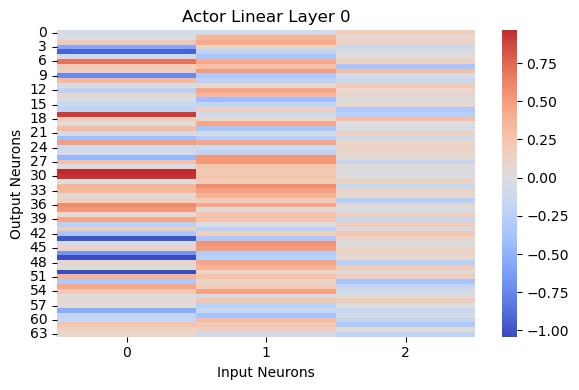

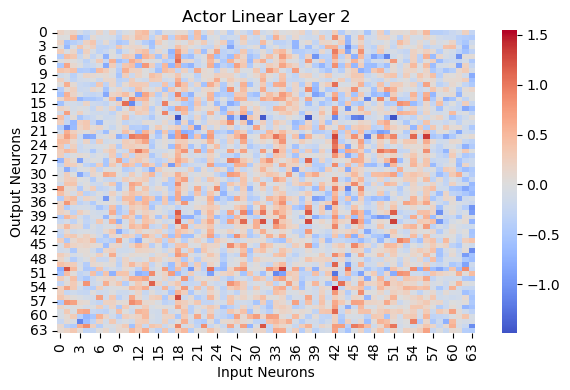

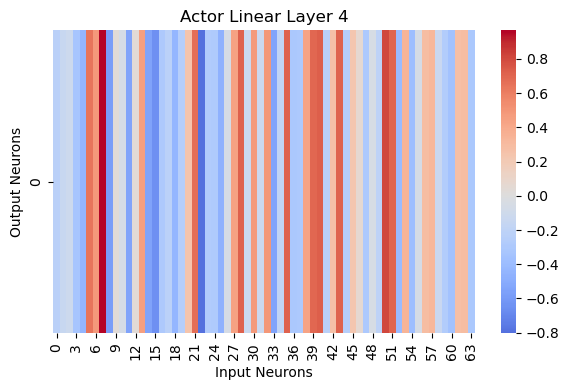

In [4]:
def visualize_weights(weights, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(weights, cmap='coolwarm', center=0)
    plt.title(title)
    plt.xlabel("Input Neurons")
    plt.ylabel("Output Neurons")
    plt.tight_layout()
    plt.show()

def visualize_model_weights(model, name="Model"):
    for i, layer in enumerate(model):
        # Standard linear layer
        if isinstance(layer, nn.Linear):
            w = layer.weight.detach().cpu().numpy()
            visualize_weights(w, f"{name} Linear Layer {i}")
        
        elif hasattr(layer, "linear") and isinstance(layer.linear, nn.Linear):
            w = layer.linear.weight.detach().cpu().numpy()
            visualize_weights(w, f"{name} Siren Layer {i}")
# Visualize
visualize_model_weights(actor, "Actor")

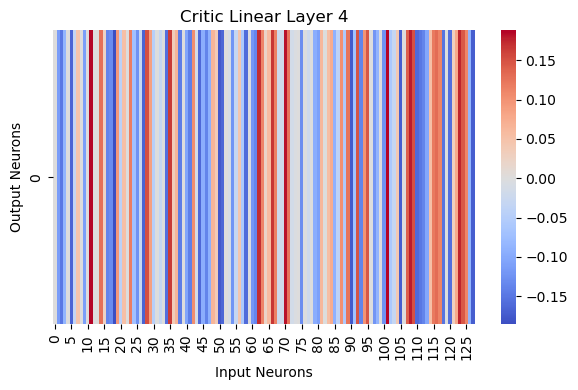

In [5]:
visualize_model_weights(critic, "Critic")

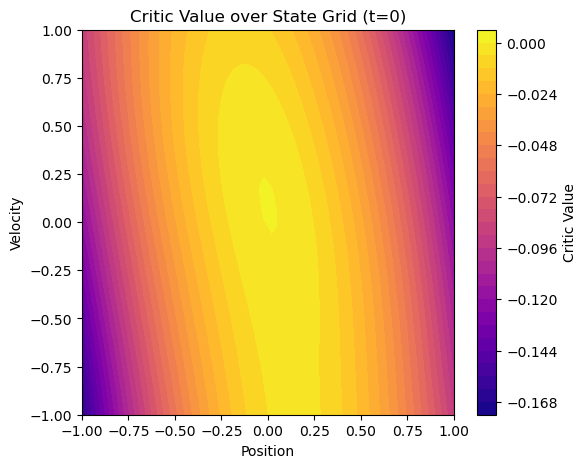

In [6]:
x = np.linspace(-1, 1, 50)
v = np.linspace(-1, 1, 50)
X, V = np.meshgrid(x, v)
T = 0.0 * np.ones_like(X)

# Stack into state vectors: shape (N, 3)
states = np.stack([X.ravel(), V.ravel(), T.ravel()], axis=1)
states_tensor = torch.tensor(states, dtype=torch.float32)

# Get critic values
with torch.no_grad():
    values = ac_net.eval(critic, states_tensor).cpu().numpy().reshape(X.shape)

# Plot
plt.figure(figsize=(6,5))
contour = plt.contourf(X, V, values, levels=30, cmap='plasma')
plt.colorbar(contour, label='Critic Value')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Critic Value over State Grid (t=0)')
plt.show()

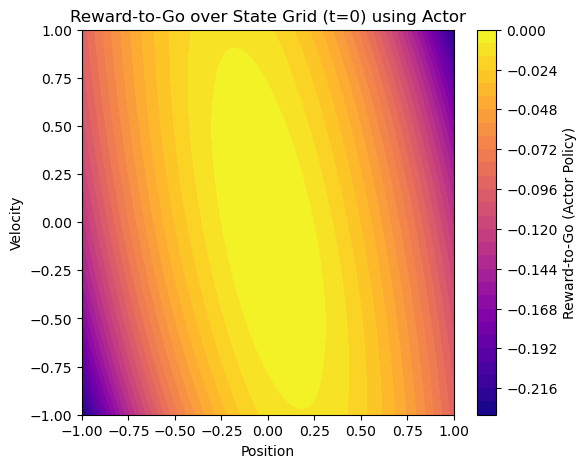

In [7]:
# Compute actual reward-to-go values using compute_partial_rtg for each grid state, with actor actions
rtg_values = np.zeros_like(X)
trainer = RLTrainer(env, None, conf, N_try=0)

for idx, (p, v) in enumerate(zip(X.ravel(), V.ravel())):
    init_state = np.array([p, v, 0.0])
    states = np.zeros((conf.NSTEPS + 1, conf.nx + 1))
    states[0] = init_state
    actions = np.zeros((conf.NSTEPS, conf.nu))
    for t in range(conf.NSTEPS):
        # Prepare state for actor (batch of 1)
        state_tensor = torch.tensor(states[t][None], dtype=torch.float32)
        with torch.no_grad():
            action = ac_net.eval(actor, state_tensor, is_actor=True).cpu().numpy().squeeze()
        actions[t] = action
        # Simulate next state
        states[t + 1] = env.simulate(states[t], actions[t])
        # states[t + 1, :2] = 0
    _, rtg, _, _, _ = trainer.compute_partial_rtg(actions, states)
    rtg_values.ravel()[idx] = rtg[0]

# Plot the RTG values
plt.figure(figsize=(6,5))
contour = plt.contourf(X, V, rtg_values, levels=30, cmap='plasma')
plt.colorbar(contour, label='Reward-to-Go (Actor Policy)')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Reward-to-Go over State Grid (t=0) using Actor')
plt.show()

   t |        x |        v |        u
----------------------------------------
   0 |    1.000 |    1.000 |   -4.987
   1 |    1.100 |    0.501 |   -4.983
   2 |    1.150 |    0.003 |   -4.898
   3 |    1.150 |   -0.487 |   -4.380
   4 |    1.102 |   -0.925 |   -2.921
   5 |    1.009 |   -1.217 |   -1.237
   6 |    0.888 |   -1.341 |   -0.251
   7 |    0.754 |   -1.366 |    0.500
   8 |    0.617 |   -1.316 |    1.000
   9 |    0.485 |   -1.216 |    1.305
  10 |    0.364 |   -1.085 |    1.516
  11 |    0.255 |   -0.934 |    1.589
  12 |    0.162 |   -0.775 |    1.562
  13 |    0.084 |   -0.618 |    1.509
  14 |    0.023 |   -0.468 |    1.397
  15 |   -0.024 |   -0.328 |    1.210
  16 |   -0.057 |   -0.207 |    0.990
  17 |   -0.078 |   -0.108 |    0.815
  18 |   -0.088 |   -0.026 |    0.640
  19 |   -0.091 |    0.038 |    0.474
  20 |   -0.087 |    0.085 |    0.314
  21 |   -0.079 |    0.116 |    0.148
  22 |   -0.067 |    0.131 |   -0.013
  23 |   -0.054 |    0.130 |   -0.131
  24 |   

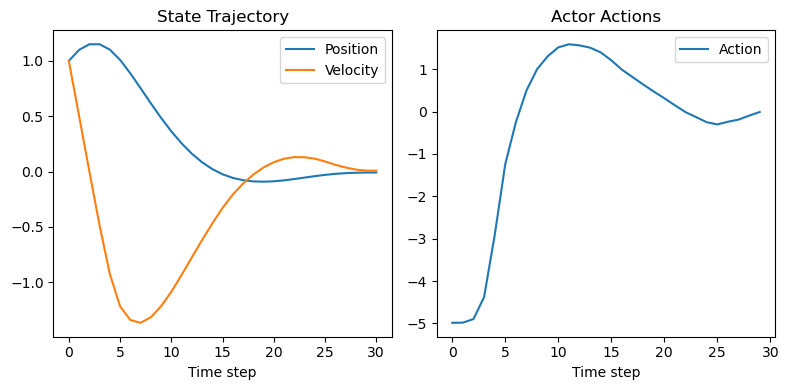

In [8]:
# Test the actor with a single trajectory rollout from an initial state
T = 0.0
steps = conf.NSTEPS - int(T / conf.dt)
init_state = np.array([1.0, 1.0, T])  # Example initial state: [position, velocity, time]
states = np.zeros((steps + 1, conf.nx + 1))
states[0] = init_state
actions = np.zeros((steps, conf.nu))

print(f"{'t':>4} | {'x':>8} | {'v':>8} | {'u':>8}")
print("-" * 40)

for t in range(steps):
    state_tensor = torch.tensor(states[t][None], dtype=torch.float32)
    with torch.no_grad():
        action = ac_net.eval(actor, state_tensor, is_actor=True).cpu().numpy().squeeze()
    print(f"{t:4d} | {states[t, 0]:8.3f} | {states[t, 1]:8.3f} | {action:8.3f}")
    actions[t] = action
    states[t + 1] = env.simulate(states[t], actions[t])

# Plot the trajectory
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(states[:,0], label='Position')
plt.plot(states[:,1], label='Velocity')
plt.xlabel('Time step')
plt.title('State Trajectory')
plt.legend()

plt.subplot(1,2,2)
plt.plot(actions, label='Action')
plt.xlabel('Time step')
plt.title('Actor Actions')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
warmstart_states, warmstart_actions = states, actions

In [10]:
TO.solve_double_integrator_unconstrained_SQP(
    warmstart_states, warmstart_actions, display_flag=True)

Iteration 0: Constraint Violation = 0.000000, Running Cost = 169.999999, Alpha = 1.000000, KKT Norm = 43.340636
Iteration 1: Constraint Violation = 0.000000, Running Cost = 169.999999, Alpha = 1.000000, KKT Norm = 0.000000


(array([[ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00],
        [ 1.10000000e+00, -5.99999983e-01,  1.00000000e-01],
        [ 1.04000000e+00, -1.33999997e+00,  2.00000000e-01],
        [ 9.06000004e-01, -1.57599996e+00,  3.00000000e-01],
        [ 7.48400008e-01, -1.53639996e+00,  4.00000000e-01],
        [ 5.94760013e-01, -1.36295995e+00,  5.00000000e-01],
        [ 4.58464017e-01, -1.13994395e+00,  6.00000000e-01],
        [ 3.44469622e-01, -9.14441559e-01,  7.00000000e-01],
        [ 2.53025466e-01, -7.10246219e-01,  8.00000000e-01],
        [ 1.82000844e-01, -5.37123959e-01,  9.00000000e-01],
        [ 1.28288448e-01, -3.96850494e-01,  1.00000000e+00],
        [ 8.86033991e-02, -2.87028820e-01,  1.10000000e+00],
        [ 5.99005171e-02, -2.03415285e-01,  1.20000000e+00],
        [ 3.95589886e-02, -1.41267282e-01,  1.30000000e+00],
        [ 2.54322604e-02, -9.60670111e-02,  1.40000000e+00],
        [ 1.58255593e-02, -6.38608684e-02,  1.50000000e+00],
        [ 9.43947246e-03

In [11]:
init_states, init_actions = np.zeros_like(warmstart_states), np.zeros_like(warmstart_actions)
init_states[0,:] = warmstart_states[0,:]  # Start from the same initial state
TO.solve_double_integrator_unconstrained_SQP(
    init_states, init_actions, display_flag=True)

Iteration 0: Constraint Violation = 0.000000, Running Cost = 169.999999, Alpha = 1.000000, KKT Norm = 85.905323
Iteration 1: Constraint Violation = 0.000000, Running Cost = 169.999999, Alpha = 1.000000, KKT Norm = 0.000000


(array([[ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00],
        [ 1.10000000e+00, -5.99999983e-01,  0.00000000e+00],
        [ 1.04000000e+00, -1.33999997e+00,  0.00000000e+00],
        [ 9.06000004e-01, -1.57599996e+00,  0.00000000e+00],
        [ 7.48400008e-01, -1.53639996e+00,  0.00000000e+00],
        [ 5.94760013e-01, -1.36295995e+00,  0.00000000e+00],
        [ 4.58464017e-01, -1.13994395e+00,  0.00000000e+00],
        [ 3.44469622e-01, -9.14441559e-01,  0.00000000e+00],
        [ 2.53025466e-01, -7.10246219e-01,  0.00000000e+00],
        [ 1.82000844e-01, -5.37123959e-01,  0.00000000e+00],
        [ 1.28288448e-01, -3.96850494e-01,  0.00000000e+00],
        [ 8.86033991e-02, -2.87028820e-01,  0.00000000e+00],
        [ 5.99005171e-02, -2.03415285e-01,  0.00000000e+00],
        [ 3.95589886e-02, -1.41267282e-01,  0.00000000e+00],
        [ 2.54322604e-02, -9.60670111e-02,  0.00000000e+00],
        [ 1.58255593e-02, -6.38608684e-02,  0.00000000e+00],
        [ 9.43947246e-03

/tmp/ipykernel_110451/2331490421.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost_actor[i, j] = env.running_cost(x_guess)
/tmp/ipykernel_110451/2331490421.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost_zero[i, j] = env.running_cost(x_guess)


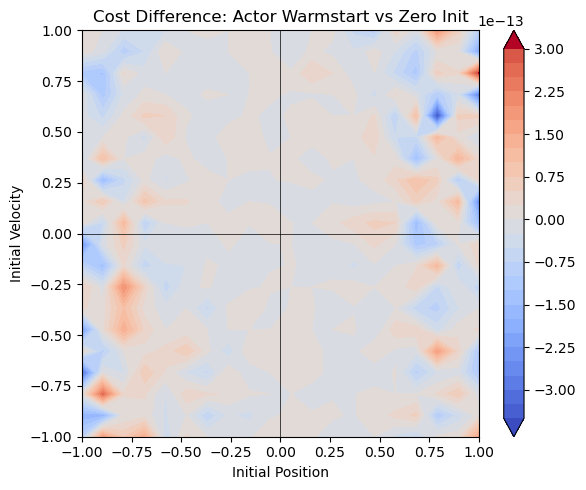

In [12]:
positions = np.linspace(-1.0, 1.0, 20)
velocities = np.linspace(-1.0, 1.0, 20)
T = 1.5

cost_actor = np.zeros((len(velocities), len(positions)))
cost_zero = np.zeros_like(cost_actor)

for i, v in enumerate(velocities):
    for j, p in enumerate(positions):
        steps = conf.NSTEPS - int(T / conf.dt)
        init_state = np.array([p, v, T])

        # --- Actor rollout ---
        states = np.zeros((steps + 1, conf.nx + 1))
        actions = np.zeros((steps, conf.nu))
        states[0] = init_state
        for t in range(steps):
            state_tensor = torch.tensor(states[t][None], dtype=torch.float32)
            with torch.no_grad():
                action = ac_net.eval(actor, state_tensor, is_actor=True).cpu().numpy().squeeze()
            actions[t] = action
            states[t + 1] = env.simulate(states[t], actions[t])

        # === TO with actor warm start ===
        try:
            opt_states, opt_actions, _, _ = TO.solve_double_integrator_unconstrained_SQP(
                states, actions, display_flag=False
            )

            N = opt_states.shape[0]
            nx, nu = conf.nx, conf.nu
            num_vars = (N - 1) * (nx + nu) + nx
            x_guess = np.zeros((num_vars, 1))
            for k in range(N - 1):
                idx = k * (nx + nu)
                x_guess[idx:idx + nx, 0] = opt_states[k, :2]
                x_guess[idx + nx, 0] = opt_actions[k, 0]
            x_guess[-nx:, 0] = opt_states[-1, :2]
            cost_actor[i, j] = env.running_cost(x_guess)

        except:
            cost_actor[i, j] = np.nan

        # === TO with zero warm start ===
        try:
            # Build zeros trajectory with time
            zero_states = np.zeros((steps + 1, conf.nx + 1))
            zero_states[:, 2] = np.linspace(T, T + conf.dt * steps, steps + 1)
            zero_states[0, :2] = [p, v]
            zero_actions = np.zeros((steps, conf.nu))

            opt_states, opt_actions, _, _ = TO.solve_double_integrator_unconstrained_SQP(
                zero_states, zero_actions, display_flag=False
            )

            N = opt_states.shape[0]
            x_guess = np.zeros((num_vars, 1))
            for k in range(N - 1):
                idx = k * (nx + nu)
                x_guess[idx:idx + nx, 0] = opt_states[k, :2]
                x_guess[idx + nx, 0] = opt_actions[k, 0]
            x_guess[-nx:, 0] = opt_states[-1, :2]
            cost_zero[i, j] = env.running_cost(x_guess)

        except:
            cost_zero[i, j] = np.nan

# === Compute cost difference ===
cost_diff = cost_actor - cost_zero  # positive = actor worse, negative = actor better

# === Plot difference ===
vmax = np.nanmax(np.abs(cost_diff))
import matplotlib.colors as mcolors
norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

plt.figure(figsize=(6, 5))
X, Y = np.meshgrid(positions, velocities)
contour = plt.contourf(X, Y, cost_diff, levels=30, cmap='coolwarm', norm=norm, extend='both')
plt.colorbar(contour)
plt.xlabel('Initial Position')
plt.ylabel('Initial Velocity')
plt.title('Cost Difference: Actor Warmstart vs Zero Init')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

In [13]:
np.mean(cost_diff)

np.float64(-4.255970575961499e-15)